In [18]:
import sys, os, re
import importlib
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d, percentile_filter
from scipy.stats import binned_statistic, zscore
import scipy.stats as stats
import suite2p 
from suite2p.extraction import dcnv
import pandas as pd
import yaml
import copy
import glob 
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import wesanderson
from cycler import cycler
import palettes
pio.renderers.default = "browser"

import neural_analysis_helpers
importlib.reload(neural_analysis_helpers)

from neural_analysis_helpers import get_psth, plot_avg_psth, split_psth, get_tuned_neurons, plot_avg_goal_psth, \
    get_landmark_psth, plot_avg_landmark_psth, plot_landmark_psth_map, plot_condition_psth_map, get_map_correlation, \
    get_tuned_neurons_shohei

tm_palette = palettes.met_brew('Tam',n=123, brew_type="continuous")
tm_palette = tm_palette[::-1]
color_scheme = wesanderson.film_palette('Darjeeling Limited',palette=0)
custom_cycler = cycler(color=color_scheme)

In [2]:
# Load tracked and aligned ROIs
sessions_to_align = ['ses-011_date-20250315_protocol-t5', 'ses-012_date-20250318_protocol-t6']
num_sessions = len(sessions_to_align)
protocol_nums = [int(re.search(r'protocol-t(\d+)', s).group(1)) for s in sessions_to_align]

basepath = Path('/Volumes/mrsic_flogel/public/projects/AtApSuKuSaRe_20250129_HFScohort2')
animal = 'TAA0000066'
func_img_path = 'funcimg/Session'
tracking_path = basepath / animal / '_'.join(f't{n}' for n in protocol_nums)
savepath = tracking_path / 'analysis' 

suffix = '_'.join(f't{n}' for n in protocol_nums)
filename = f'roicat_aligned_ROIs_{suffix}.npy'
if os.path.exists(os.path.join(tracking_path, filename)):
    idx_original_aligned = np.load(os.path.join(tracking_path, filename))
else:
    raise FileNotFoundError('The ROICaT alignment file is not found in this directory.')
    

In [3]:
# Load DF_F 
session_data = [[] for s in range(num_sessions)]

for s, sess in enumerate(sessions_to_align):
    DF_F_file = os.path.join(basepath, animal, sess, func_img_path, 'suite2p/plane0/DF_F0.npy')
    valid_frames_file = os.path.join(basepath, animal, sess, 'valid_frames.npz')

    if os.path.exists(DF_F_file) and os.path.exists(valid_frames_file):
        valid_frames = np.load(valid_frames_file)['valid_frames']

        DF_F_all = np.load(DF_F_file)
        DF_F = DF_F_all[:, valid_frames]
        session_data[s] = DF_F
    else:
        raise FileNotFoundError('Either the valid_frames.npz or the DF_F0.npy file does not exist in this directory.')


Common neurons considered across all sessions: 155


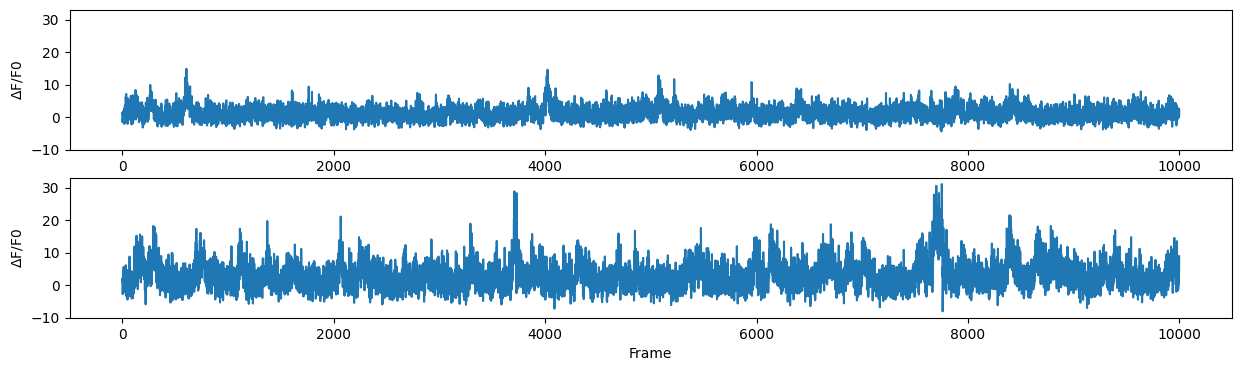

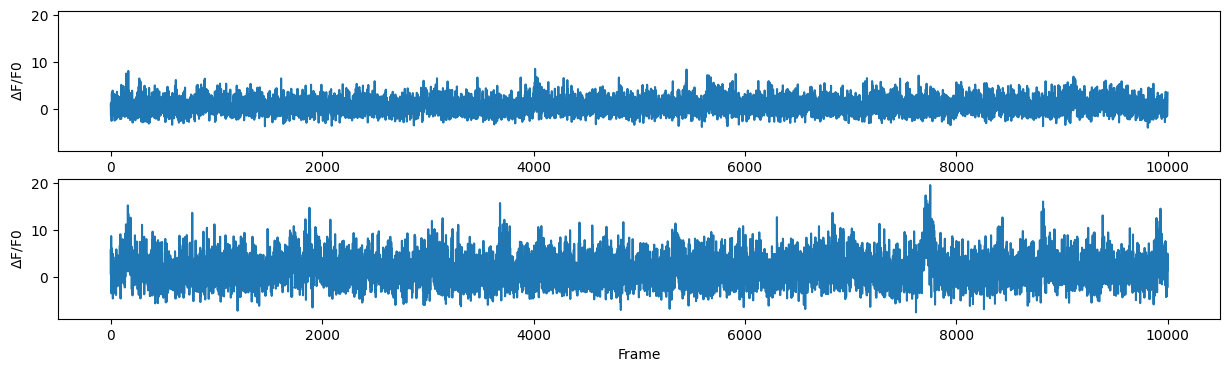

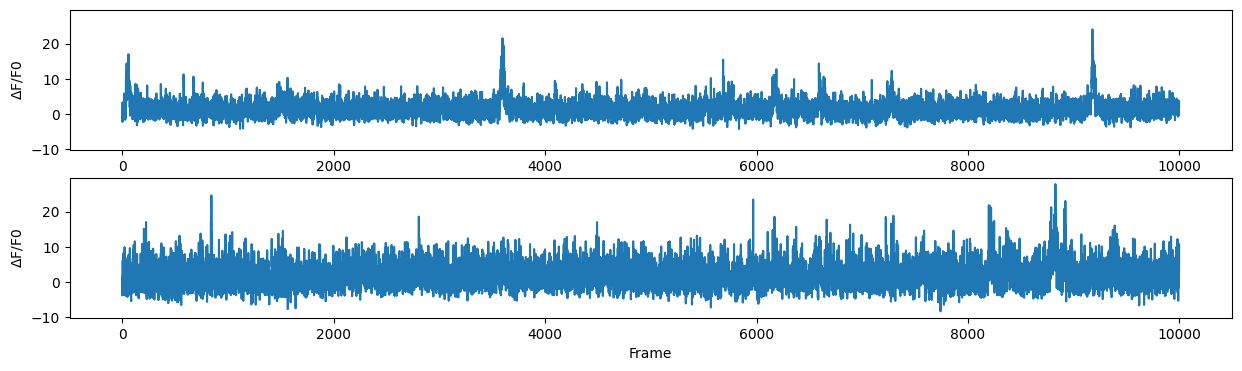

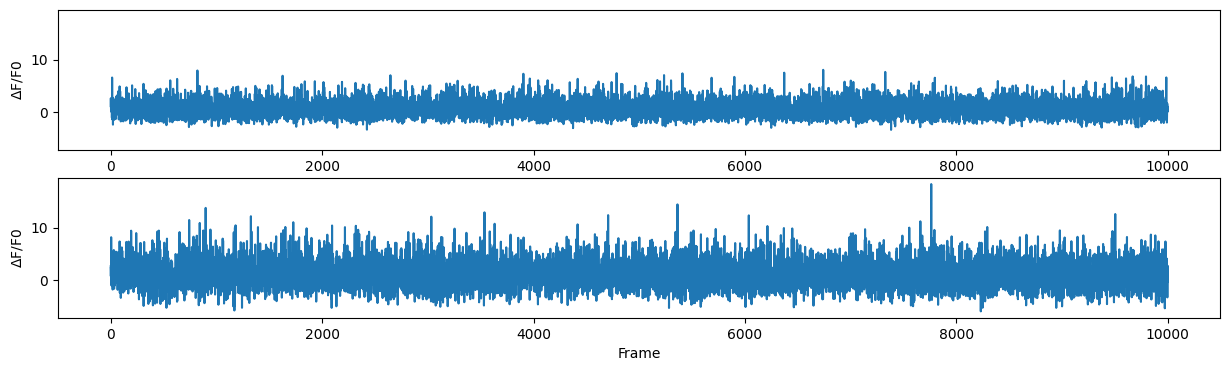

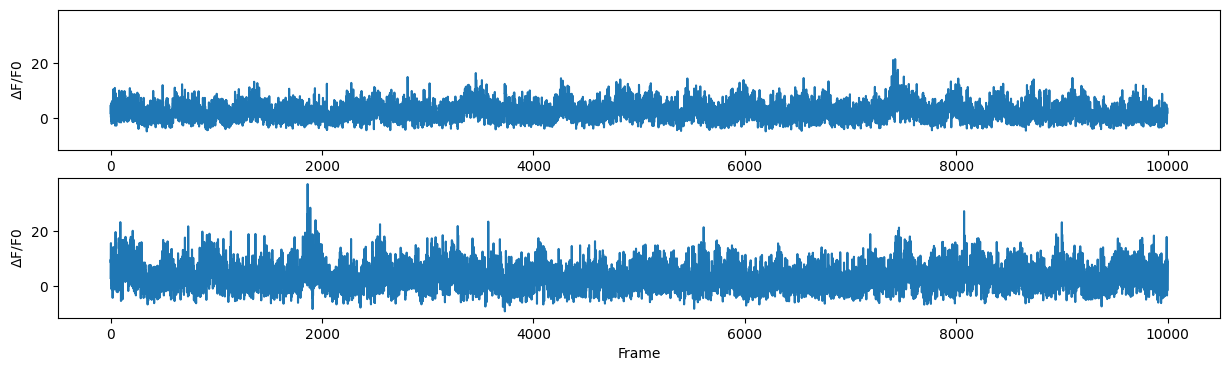

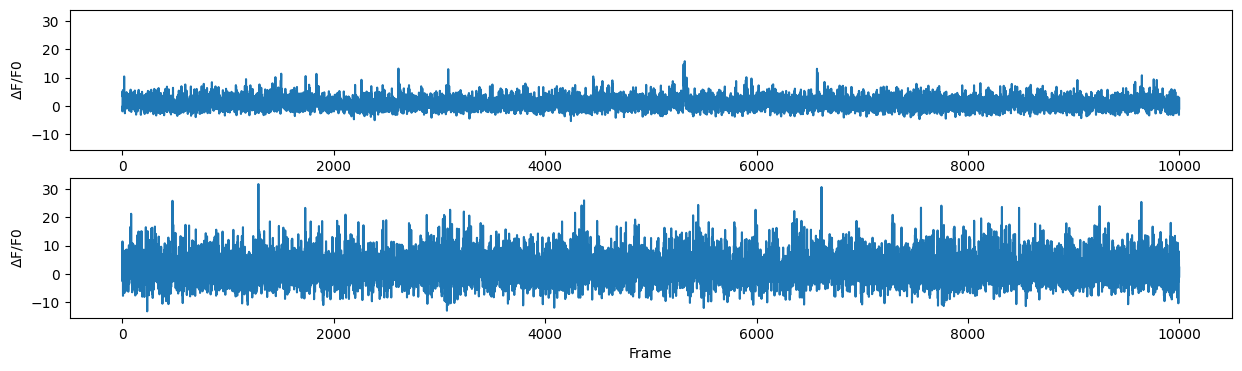

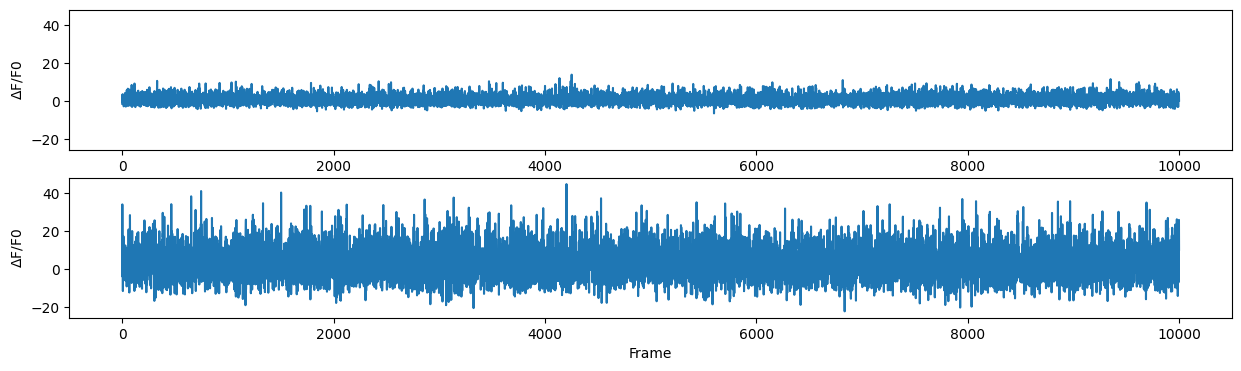

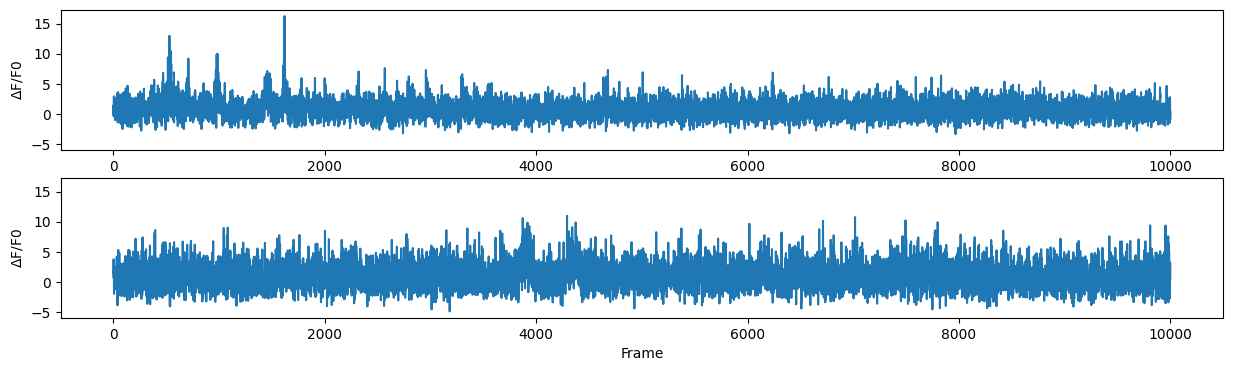

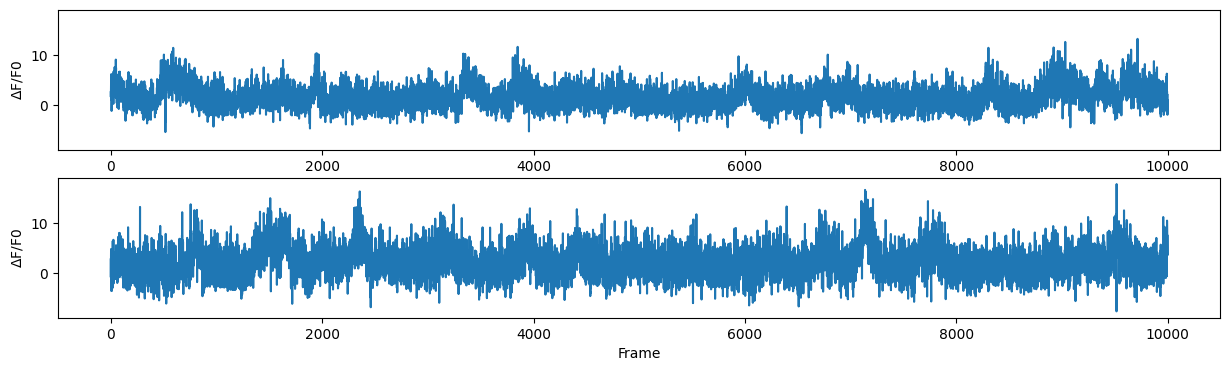

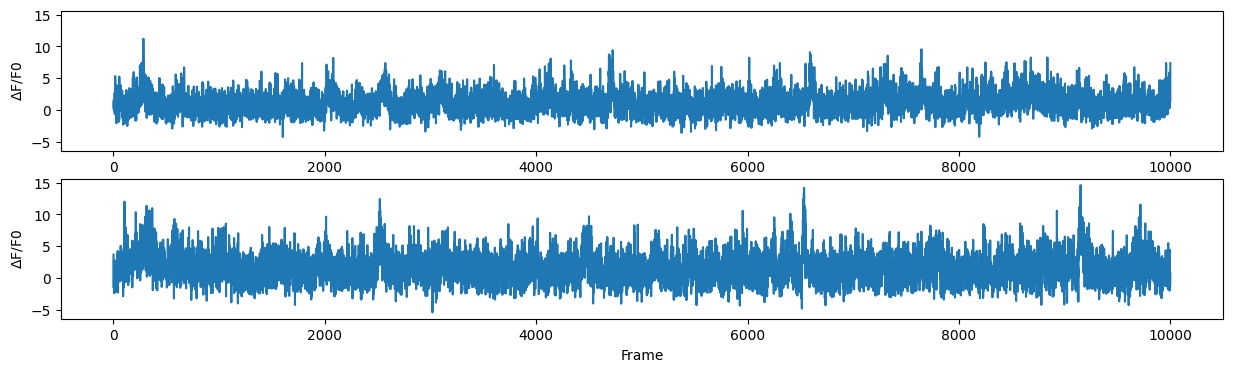

In [ ]:
# Look at distribution of DF/F to select neurons

# Keep neurons that have been clustered in all sessions
idx_array = np.vstack(idx_original_aligned)  # shape: (n_sessions, n_neurons)
valid_mask = np.all(~np.isnan(idx_array), axis=0)  # Find neurons that are not nan in all sessions
valid_indices = np.where(valid_mask)[0]  # Get the indices that are valid across all sessions

# Find indices of neurons that have good signal in all sessions and are tracked across sessions
consistent_neurons = [[] for s in range(num_sessions)]
for s in range(num_sessions):
    for n, neuron in enumerate(np.array(idx_original_aligned[s][valid_indices]).astype(int)):
        deltas = session_data[s][neuron,:] - np.mean(session_data[s][neuron,:])
        # plt.hist(deltas, bins=100)
        skew = stats.skew(deltas)

        if skew > 0.5:
            consistent_neurons[s].append(n)

neuron_sets = [set(neurons) for neurons in consistent_neurons]
common_neuron_idx = list(set.intersection(*neuron_sets))  # indices of neurons
print("Common neurons considered across all sessions:", len(common_neuron_idx))

# Get the ids of these neurons  
neurons_considered_sessions = [[] for s in range(num_sessions)]  
for s in range(num_sessions):
    for neuron in np.array(idx_original_aligned[s][valid_indices[common_neuron_idx]]).astype(int):
        neurons_considered_sessions[s].append(neuron)

# Plot a few neurons
plot_range = 10000
xdata = np.arange(0, plot_range) 
for n in range(0,10):
    fig, ax = plt.subplots(num_sessions, 1, figsize=(15,4), sharey=True)
    ax = ax.ravel()
    for s in range(num_sessions):
        ax[s].plot(xdata, session_data[s][neurons_considered_sessions[s][n],0:plot_range])
        ax[s].set_xlabel('Frame')
        ax[s].set_ylabel('$\Delta$F/F0')

In [ ]:
# Identify common neurons that are tuned to rewards
# NOTE: singificant neurons for each event are indices into that session's neurons_considered, 
# which are in turn the actual ROI ids. 
all_significant_neurons_reward = [[] for s in range(num_sessions)]
significant_neurons_reward_id = [[] for s in range(num_sessions)]
reward_tuned_neurons_sessions = [[] for s in range(num_sessions)]
neurons_considered = [[] for s in range(num_sessions)]
tracked_reward_tuned_neurons = [[] for s in range(num_sessions)] # reward-tuned neurons across sessions
tracked_reward_tuned_idx = [[] for s in range(num_sessions)]
results_rewards = [[] for s in range(num_sessions)]

for s, (prot, sess) in enumerate(zip(protocol_nums, sessions_to_align)):

    analysis_path = os.path.join(basepath, animal, sess, 'analysis')
    neurons_considered_file = np.load(os.path.join(analysis_path, f'T{prot}_neurons_considered.npz'), allow_pickle=True)
    neurons_considered[s] = neurons_considered_file['arr_0']

    results_rewards[s] = np.load(os.path.join(analysis_path, f'T{prot}_rewards_analysis.npz'), allow_pickle=True)
    all_significant_neurons_reward[s] = results_rewards[s]['all_significant_neurons_reward']

    # Reward-tuned neurons for each goal, where the keys correspond to goals: 1:A, 2:B, 3:C, 4:D
    significant_neurons_reward_id[s] = results_rewards[s]['significant_neurons_reward_id']

    # Ids of reward-tuned neurons from each session
    reward_tuned_neurons_sessions[s] = neurons_considered[s][all_significant_neurons_reward[s]]

    # Ids of reward-tuned neurons from each session that have been tracked across sessions
    tracked_reward_tuned_neurons[s] = np.intersect1d(reward_tuned_neurons_sessions[s], neurons_considered_sessions[s])
    print(f'Out of {len(neurons_considered_sessions[s])} neurons considered across all sessions, {len(tracked_reward_tuned_neurons[s])} have been previously identified as reward-tuned in T{prot}.')

    # Indices of reward-tuned neurons from each session inside the tracked array. 
    # The same indices across arrays correspond to the same neurons.
    tracked_reward_tuned_idx[s] = np.where(np.isin(neurons_considered_sessions[s], tracked_reward_tuned_neurons[s]))[0]

consistent_reward_tuned_neuron_idx = reduce(np.intersect1d, tracked_reward_tuned_idx)


Out of 155 neurons considered across all sessions, 128 have been previously identified as reward-tuned in T5.
Out of 155 neurons considered across all sessions, 143 have been previously identified as reward-tuned in T6.


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

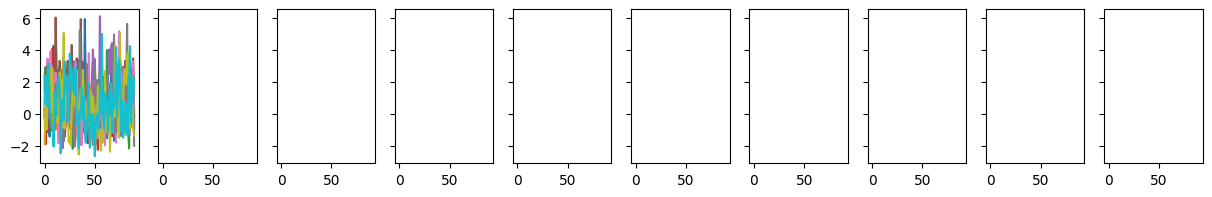

In [ ]:
# Plot reward PSTHs for each session
for s in range(num_sessions):
    neurons = np.array(neurons_considered_sessions[s])[consistent_reward_tuned_neuron_idx]
    neuron_idx = np.where(np.isin(neurons_considered[s], neurons))[0]
    # print(neurons)
    # print(neuron_idx)
    # plot_avg_landmark_psth(neurons, psth=results_rewards[s]['reward_psth'][neuron_idx], \
    #                        average_psth=results_rewards[s]['average_reward_psth'][neuron_idx], num_landmarks=10, \
    #                         time_around=1, funcimg_frame_rate=45, plot_all_neurons=False, \
    #                             save_plot=False, savepath='', savedir='')